In [1]:
%%html
<style>
.text-color {
    color: #C0302B; 
}
</style>

<p class='text-color'><b>Created on : 5/31/2023 by Shoab Ahamed </b></p>

# LIBRARIES

In [2]:
# numerical analysis
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

#  model selection & metrics
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import RocCurveDisplay, auc, classification_report, roc_auc_score, mean_absolute_error


# pipelines
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer, PowerTransformer, PolynomialFeatures
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from category_encoders import TargetEncoder, MEstimateEncoder

# dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
# clusters
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# rigression models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# models Analysis and Explainability 
from eli5.sklearn import PermutationImportance
import eli5
from sklearn.inspection import PartialDependenceDisplay
import shap


# utitlity
from copy import deepcopy
from path import Path
import warnings 
warnings.filterwarnings('ignore') # supress warnings

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

# SOME FUNCTIONS

In [3]:
def summary(_df, cats_only=False):
    """A function which summarizes the dataset given by giving us various statistical information"""
    summ = pd.DataFrame(_df.dtypes, columns=['data type'])
    summ['missing'] = _df.isnull().sum()
    summ['%missing'] = summ['missing'] / len(_df)
    summ['no_of_unique'] = _df.nunique()
    
    desc = _df.describe(include='all').transpose()
    
    if not cats_only:
        summ['min'] = desc['min'].values
        summ['max'] = desc['max'].values
        summ['mean'] = desc['mean'].values
        summ['median'] = desc['50%'].values
    
    summ['first_value'] = _df.loc[0].values.flatten()
    summ['second_value'] = _df.loc[1].values.flatten()
    summ['third_value'] = _df.loc[2].values.flatten()
    
    return summ

# plot histogram    
def plot_hist(df, x, x_label=None, title='Distribution', legend=["Median", "Mean"], **kwargs):
    '''Takes in a pandas dataframe and plot a histogram based on the feature name x provided'''
    ax = sns.histplot(data=df, x=x, **kwargs)
    ax.axvline(x=df[x].median(), color='#FFCC00', linestyle='dashed')
    # 
    ax.axvline(x=df[x].mean(), color='#00008B', linestyle='dashed')
    
    ax2 = ax.twinx()
    ax2 = sns.boxplot(data=df, x=x, ax=ax2, color=(0.7, 0.7, 0.7))
    ax2.set(ylim=(-.5, 10))
    

    
    if x_label: # set custom feature names if given
        ax.set_xlabel(x_label)
    if legend: # set custom legends if given a values
        ax.legend(labels=legend)
        
    ax.set_title(title) # sets the title of the plot
    
    
# plot categorical features  
def plot_categorical(df, x=None, y=None, violin=False, title="Count plot", legend=None, **kwargs):
    "Takes in a pandas dataframe and plot countplot if y is not given and a violin plot if y is also given"
    if y:
        if violin:
            ax = sns.violinplot(data=df, x=x, y=y, **kwargs) # plots violinplot if y is given
        else:
            ax = sns.boxplot(data=df, x=x, y=y, **kwargs)
    else:
        ax = sns.countplot(data=df, x=x, **kwargs)       # plot countplot if y is not given
        
    ax.set_title(title) # sets title
    if legend: # sets custom legend if given
        ax.legend(labels=[legend])
        
    
def correlation_dendrogram(data, feats, corr_method='spearman', orientation='top', leaf_rotation=90, label='', figsize=(15, 6), 
                          threshold=0.8):
    
    """Plots dendogram and clustered correleation based on the threshold provided which determines the number of clusters"""
    corr_df = data[feats].corr(method=corr_method)

    dist = 1- abs(corr_df)
    dist_linkage = linkage(squareform(dist), method='complete')

    fig, axes = plt.subplots(1, 1, figsize=figsize)

    dendro = dendrogram(dist_linkage, labels=feats, orientation=orientation, leaf_rotation=leaf_rotation, ax=axes)
    axes.set_title(f'Feature Distance in {label} Dataset', weight = 'bold', size = 10)


    threshold = threshold
    labels = fcluster(dist_linkage, threshold, criterion='distance')
    
    labels_order = np.argsort(labels)
#     data = data[data.columns[labels_order]]
    
    for idx, i in enumerate(data.columns[labels_order]):
        if idx == 0:
            clustered = pd.DataFrame(data[i])
        else:
            df_to_append = pd.DataFrame(data[i])
            clustered = pd.concat([clustered, df_to_append], axis=1)
    
    correlations = clustered.corr(method=corr_method)

    return correlations



def plot_pca(df, plot_var=True):
    """Takes a dataset and do pricinpal component analysis and plots the results. Do not pass target"""
    #     The code below is mostly taken from kaggle learn course Principal Component Analysis. Link is below
    # https://www.kaggle.com/code/ryanholbrook/principal-component-analysis#Example---1985-Automobiles
    _X = df.copy()
    features = _X.columns.tolist()

    # Standardize
    minmax = MinMaxScaler()
    X_scaled = minmax.fit_transform(_X)
    
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Convert to dataframe
    component_names = [f"PCA{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)

    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=_X.columns,  # and the rows are the original features
    )
    
    if plot_var:
        plot_variance(pca)
    
    return X_pca, loadings

# helper function of plot_pca
def plot_variance(pca, width=8, dpi=100):
    """"plot pca vairance given the pca object provided where the dataset is already passed"""
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr, color='#C0302B')
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-", color='#C0302B')
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=12, dpi=100)
    return axs

In [4]:
# loading datasets
path = Path("/kaggle/input/icr-identify-age-related-conditions/")

train = pd.read_csv(path / "train.csv")
greeks = pd.read_csv(path / "greeks.csv")
                                                                                                                                                         
display(train.head())

display(greeks.head())

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


In [5]:
# overall shapes
print(f"Training set has {train.shape[0]} rows and {train.shape[1]} cols")
print(f"Greeks dataset has {greeks.shape[0]} rows and {greeks.shape[1]} cols")

Training set has 617 rows and 58 cols
Greeks dataset has 617 rows and 6 cols


<div class="text-color"> 
<b>Insights:</b>
<ul>
    <li>The dataset size is too small</li>
    <li>It seems that for each observations there is corresponding values in Greeks dataset</li>
</ul>
    
</div>

In [6]:
# number of nulls in train and test set
null_train = train.isnull().sum().sum()
null_greeks = greeks.isnull().sum().sum()

print(f"Total number of nulls in train: {null_train}; greeks: {null_greeks}")

Total number of nulls in train: 131; greeks: 0


<p class="text-color">There are obiously some nulls in greeks we will explore them later</p>

In [7]:
# data types
train_dtypes = train.dtypes.value_counts()
greeks_dtypes = greeks.dtypes.value_counts()

print("Training dataset: ", end='\n')
display(train_dtypes)
print()
print("Greeks dataset: ", end='\n')
display(greeks_dtypes)

Training dataset: 


float64    55
object      2
int64       1
dtype: int64


Greeks dataset: 


object    6
dtype: int64

In [8]:
target = "Class"

# duplicates in individual dataset
train_dup = train.drop([target, 'Id'], axis=1).duplicated(keep=False).sum()
greeks_dup = train.drop(['Id'], axis=1).duplicated(keep=False).sum()


print(f"duplicates in train :{train_dup}")
print(f"duplicates in greeks: {greeks_dup}")

duplicates in train :0
duplicates in greeks: 0


In [9]:
train_summary = summary(train)
greeks_summary = summary(greeks, cats_only=True)

In [10]:
greeks_summary

,data type,missing,%missing,no_of_unique,first_value,second_value,third_value
Id,object,0,0.0,617,000ff2bfdfe9,007255e47698,013f2bd269f5
Alpha,object,0,0.0,4,B,A,A
Beta,object,0,0.0,3,C,C,C
Gamma,object,0,0.0,8,G,M,M
Delta,object,0,0.0,4,D,B,B
Epsilon,object,0,0.0,198,3/19/2019,Unknown,Unknown


In [11]:
for col in greeks:
    if col == "Id" or col == "Epsilon":
        continue
    print(f"{col}: unique values: {greeks[col].unique()}")

Alpha: unique values: ['B' 'A' 'D' 'G']
Beta: unique values: ['C' 'B' 'A']
Gamma: unique values: ['G' 'M' 'F' 'N' 'E' 'H' 'A' 'B']
Delta: unique values: ['D' 'B' 'C' 'A']


In [12]:
greeks['Epsilon'].sample(10)

609    9/16/2020
50     6/26/2019
26     3/27/2019
141    7/28/2020
328     5/8/2020
446      Unknown
505    2/28/2020
357    4/11/2019
365      Unknown
477    7/29/2020
Name: Epsilon, dtype: object

<p class="text-color"> all features in greeks are categorical with low cardianitliy other than <b>Epsilon</b> which has missing values</p>

In [13]:
train_summary

,data type,missing,%missing,no_of_unique,min,max,mean,median,first_value,second_value,third_value
Id,object,0,0.000000,617,NaN,NaN,NaN,NaN,000ff2bfdfe9,007255e47698,013f2bd269f5
AB,float64,0,0.000000,217,0.081187,6.161666,0.477149,0.354659,0.209377,0.145282,0.47003
AF,float64,0,0.000000,599,192.59328,28688.18766,3502.013221,3120.31896,3109.03329,978.76416,2635.10654
AH,float64,0,0.000000,227,85.200147,1910.123198,118.624513,85.200147,85.200147,85.200147,85.200147
AM,float64,0,0.000000,605,3.177522,630.51823,38.968552,20.53311,22.394407,36.968889,32.360553
AR,float64,0,0.000000,130,8.138688,178.943634,10.128242,8.138688,8.138688,8.138688,8.138688
AX,float64,0,0.000000,427,0.699861,38.27088,5.545576,5.031912,0.699861,3.63219,6.73284
AY,float64,0,0.000000,148,0.025578,10.315851,0.06032,0.025578,0.025578,0.025578,0.025578
AZ,float64,0,0.000000,484,3.396778,38.971568,10.566447,10.46132,9.812214,13.51779,12.82457
BC,float64,0,0.000000,259,1.2299,1463.693448,8.053012,1.2299,5.555634,1.2299,1.2299


<pre style="color:#C0302B">
Number of missing values:
    BQ: 60
    CB: 2
    CC: 3
    DU: 1
    EL: 60
    FC: 1
    FS: 2
    GL: 1
    
<b>The number of missing values is very low we can ignore them at the start</b>
</pre>


# EDA

In [14]:
num_feats = train.select_dtypes(exclude='object').drop('Class', axis=1).columns.tolist()
cat_feats = train.select_dtypes(include='object').drop("Id", axis=1).columns.tolist()

<h2> Target Analysis</h2>

In [15]:
custom_colors = ["#C0302B", "#006400"]

custom_palette = sns.color_palette(custom_colors)

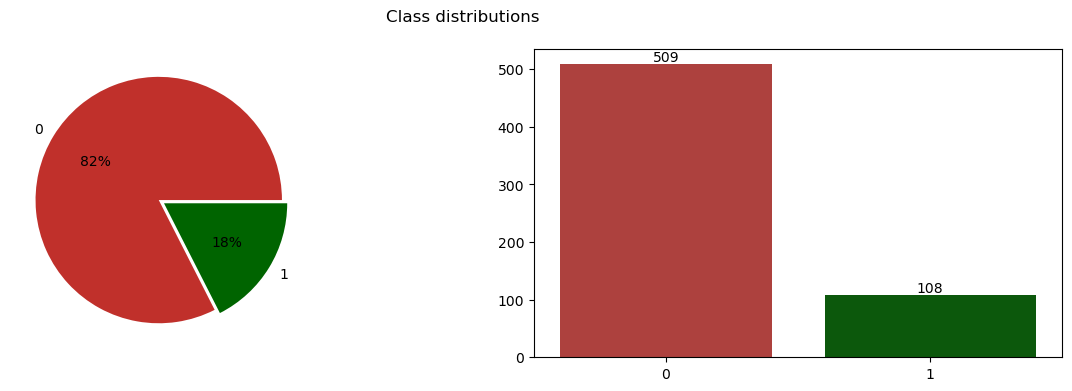

In [16]:
target_dist = train[target].value_counts()

fig, ax =plt.subplots(1, 2, figsize=(15, 4))
ax[0].pie(x=target_dist.values, labels=target_dist.index, autopct='%1.0f%%', explode=[0.05, 0], colors=["#C0302B", "#006400"])

plt.subplot(1, 2, 2)
ax2 = sns.barplot(x=target_dist.index, y=target_dist.values, ax=ax[1], palette=custom_palette)
ax2.bar_label(ax2.containers[0])

fig.suptitle("Class distributions");

<div class="text-color"> 
<b>Insights:</b>
<ul>
    <li>The target values is imbalanced</li>
</ul>
    
</div>

## Numerical Features

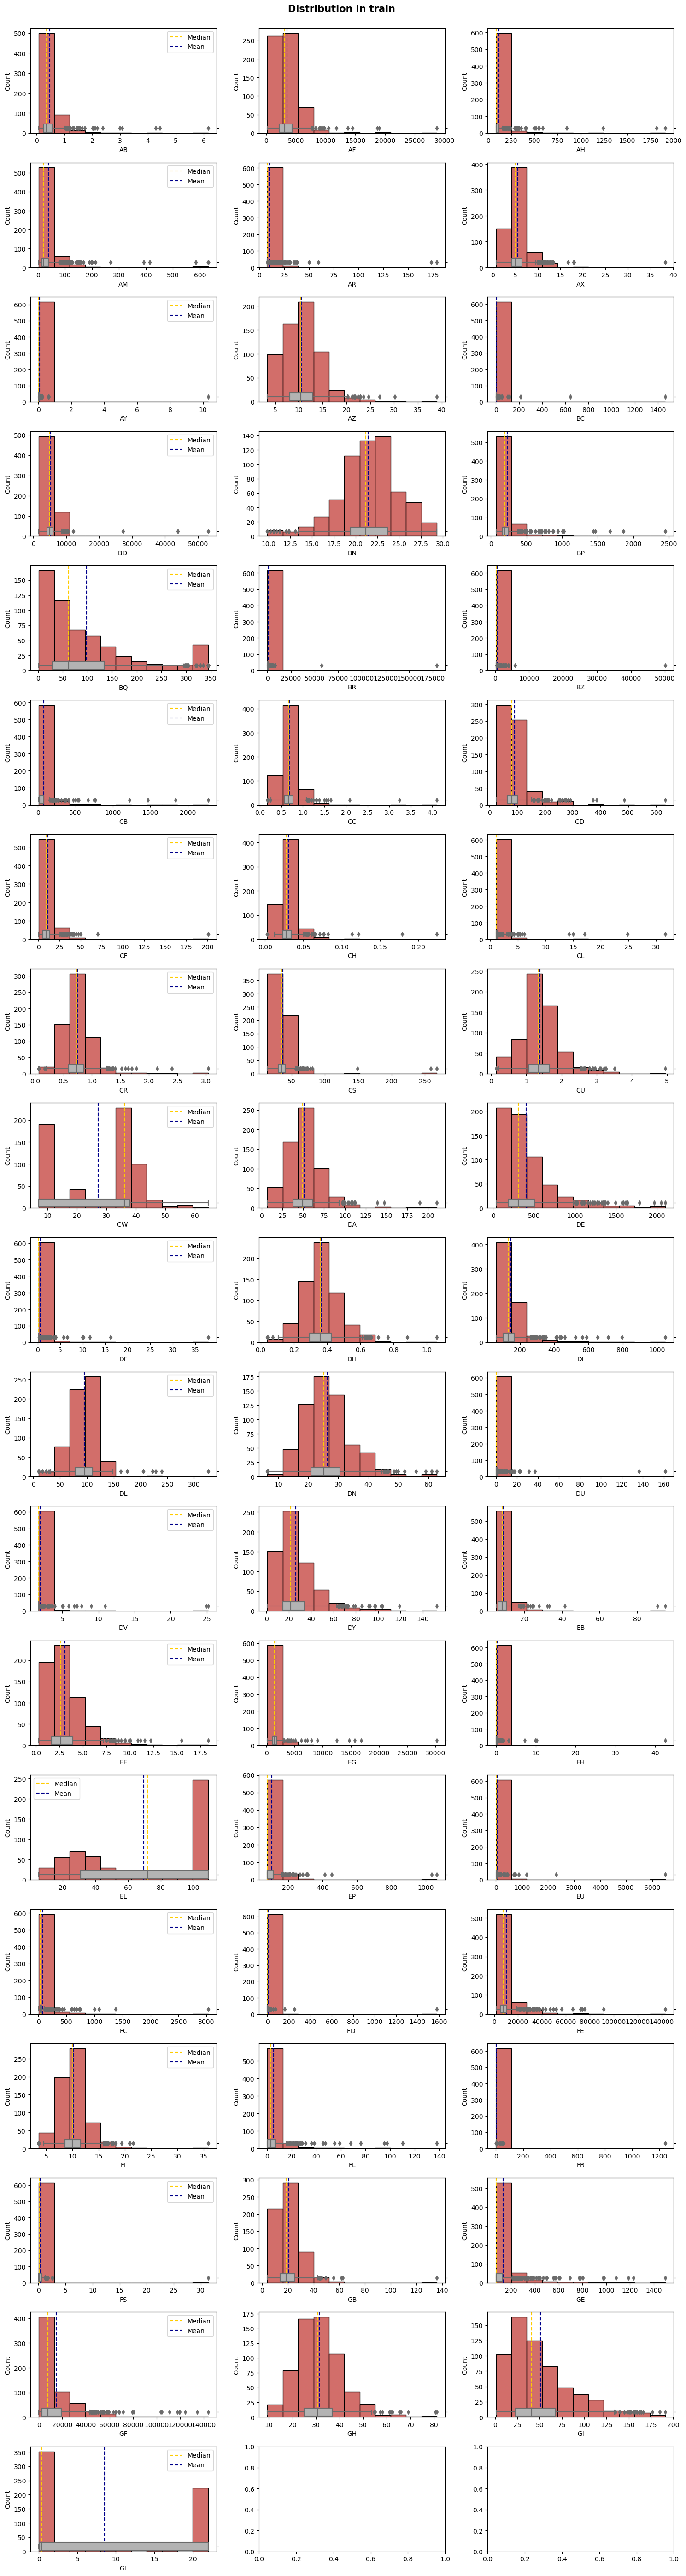

In [17]:
def get_nbins(df):
    return int(np.ceil(np.log2(len(df)) + 1))

ncols = 3
nrows = int(np.ceil(len(num_feats) / ncols))
train_nbins = get_nbins(train)


fig, ax = plt.subplots(nrows, ncols, figsize=(15, 3*nrows))
axes =  ax.flatten()

for index, col in enumerate(num_feats):
    if index % 3 == 0:
        legend = ["Median", "Mean"]
    else:
        legend = []
        
    plot_hist(train, col, legend=legend, title=None, ax=axes[index], bins=train_nbins, color="#C0302B", alpha=0.7)

fig.suptitle("Distribution in train \n\n\n\n\n", fontsize=15, fontweight='bold')    
plt.tight_layout()

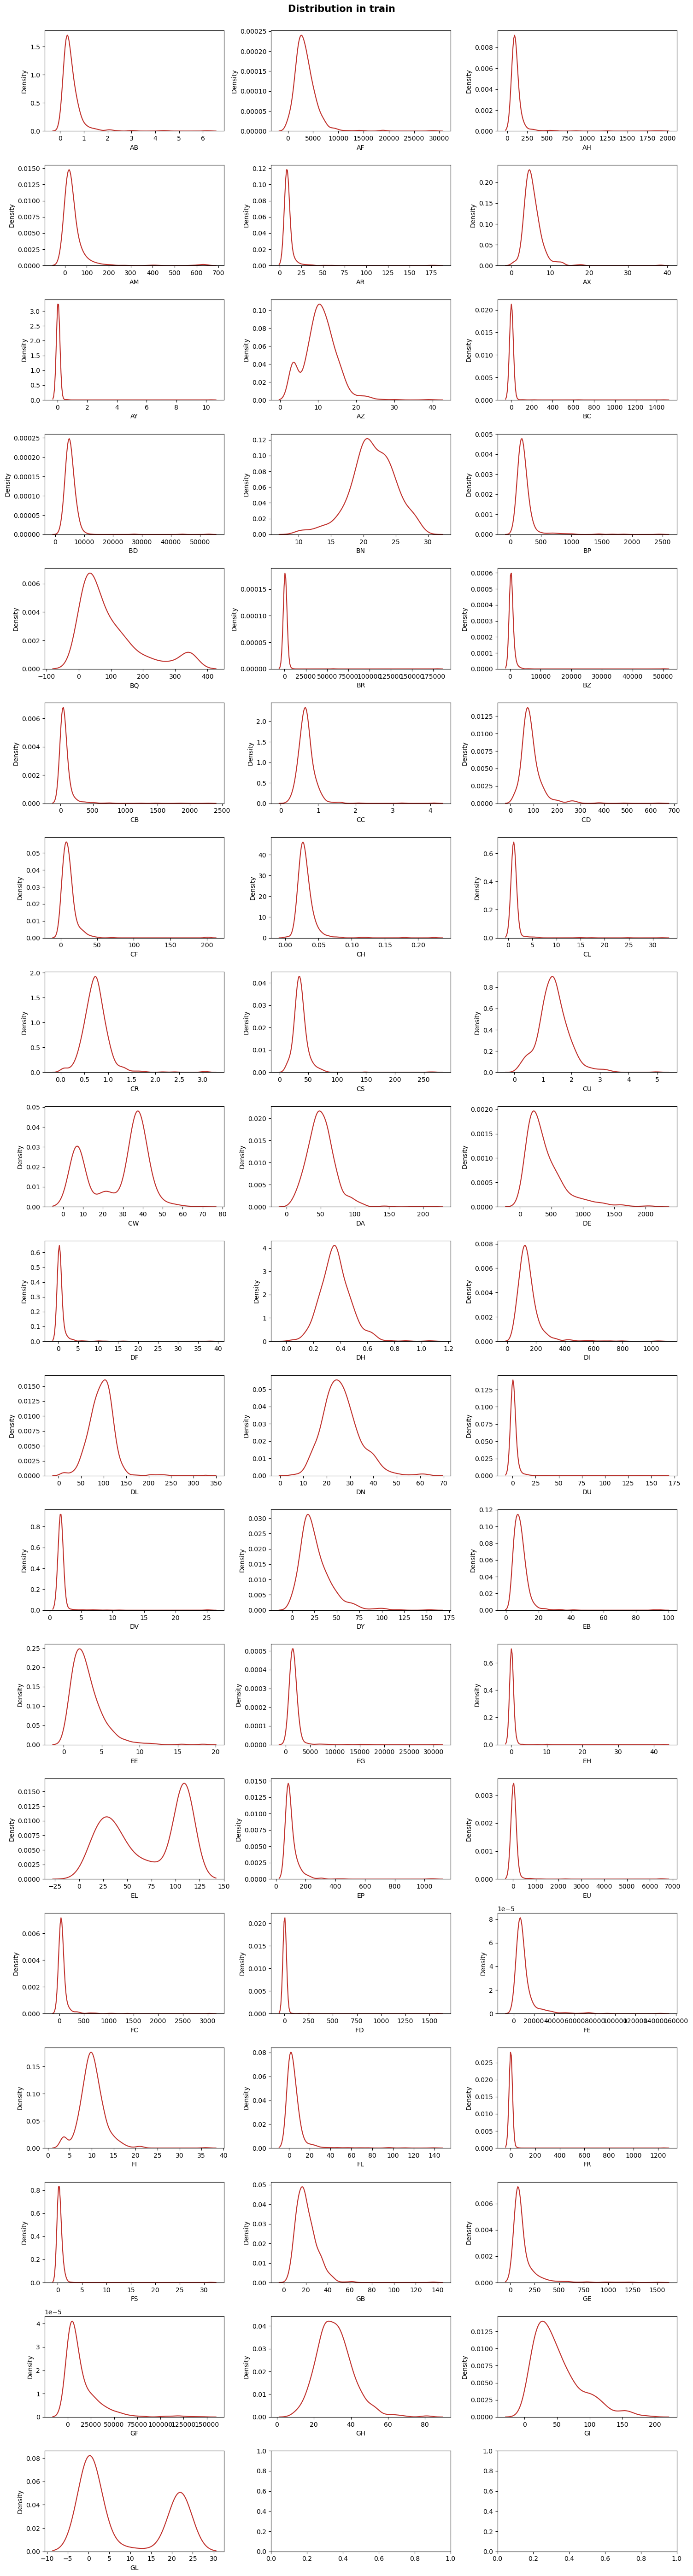

In [18]:
ncols = 3
nrows = int(np.ceil(len(num_feats) / ncols))
train_nbins = get_nbins(train)


fig, ax = plt.subplots(nrows, ncols, figsize=(15, 3*nrows))
axes =  ax.flatten()

for index, col in enumerate(num_feats):
    sns.kdeplot(data=train, x=col, ax=axes[index], color="#C0302B")
    

fig.suptitle("Distribution in train \n\n\n\n\n", fontsize=15, fontweight='bold')    
plt.tight_layout()

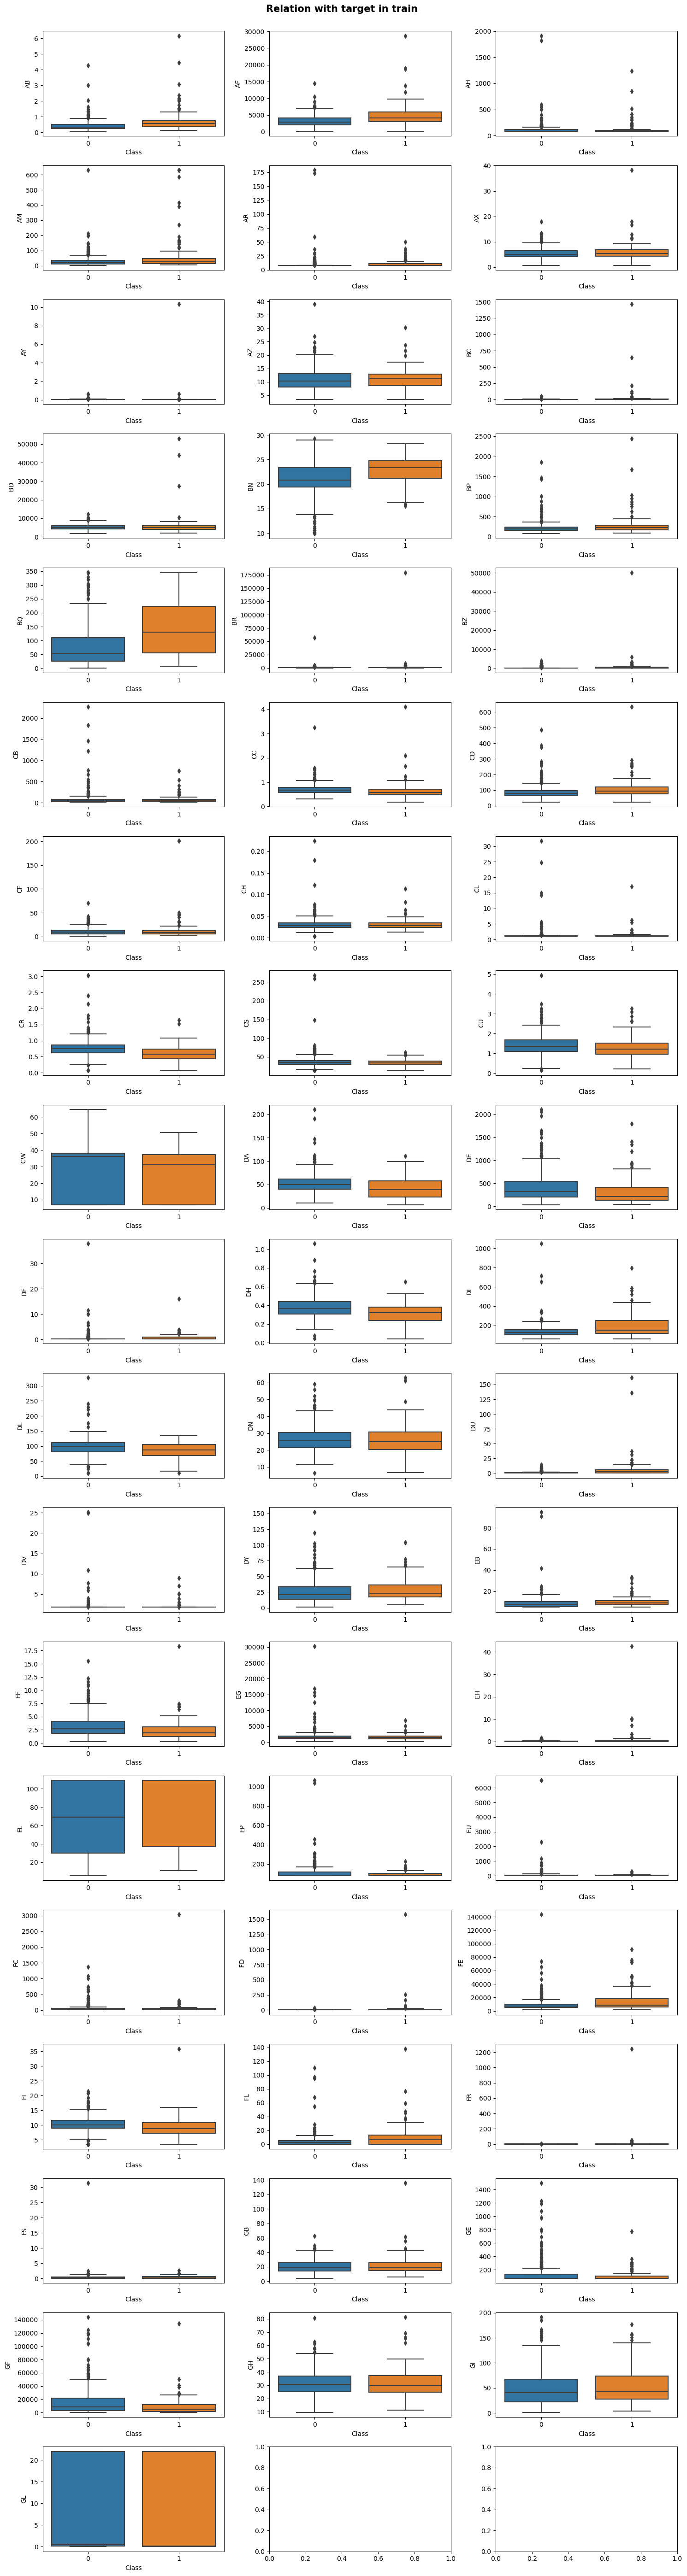

In [19]:
ncols = 3
nrows = int(np.ceil(len(num_feats) / ncols))
train_nbins = get_nbins(train)


fig, ax = plt.subplots(nrows, ncols, figsize=(15, 3*nrows))
axes =  ax.flatten()

for index, col in enumerate(num_feats):
    plot_categorical(train, x=target, y=col, ax=axes[index], title="")
    

fig.suptitle("Relation with target in train \n\n\n\n\n", fontsize=15, fontweight='bold')    
plt.tight_layout()

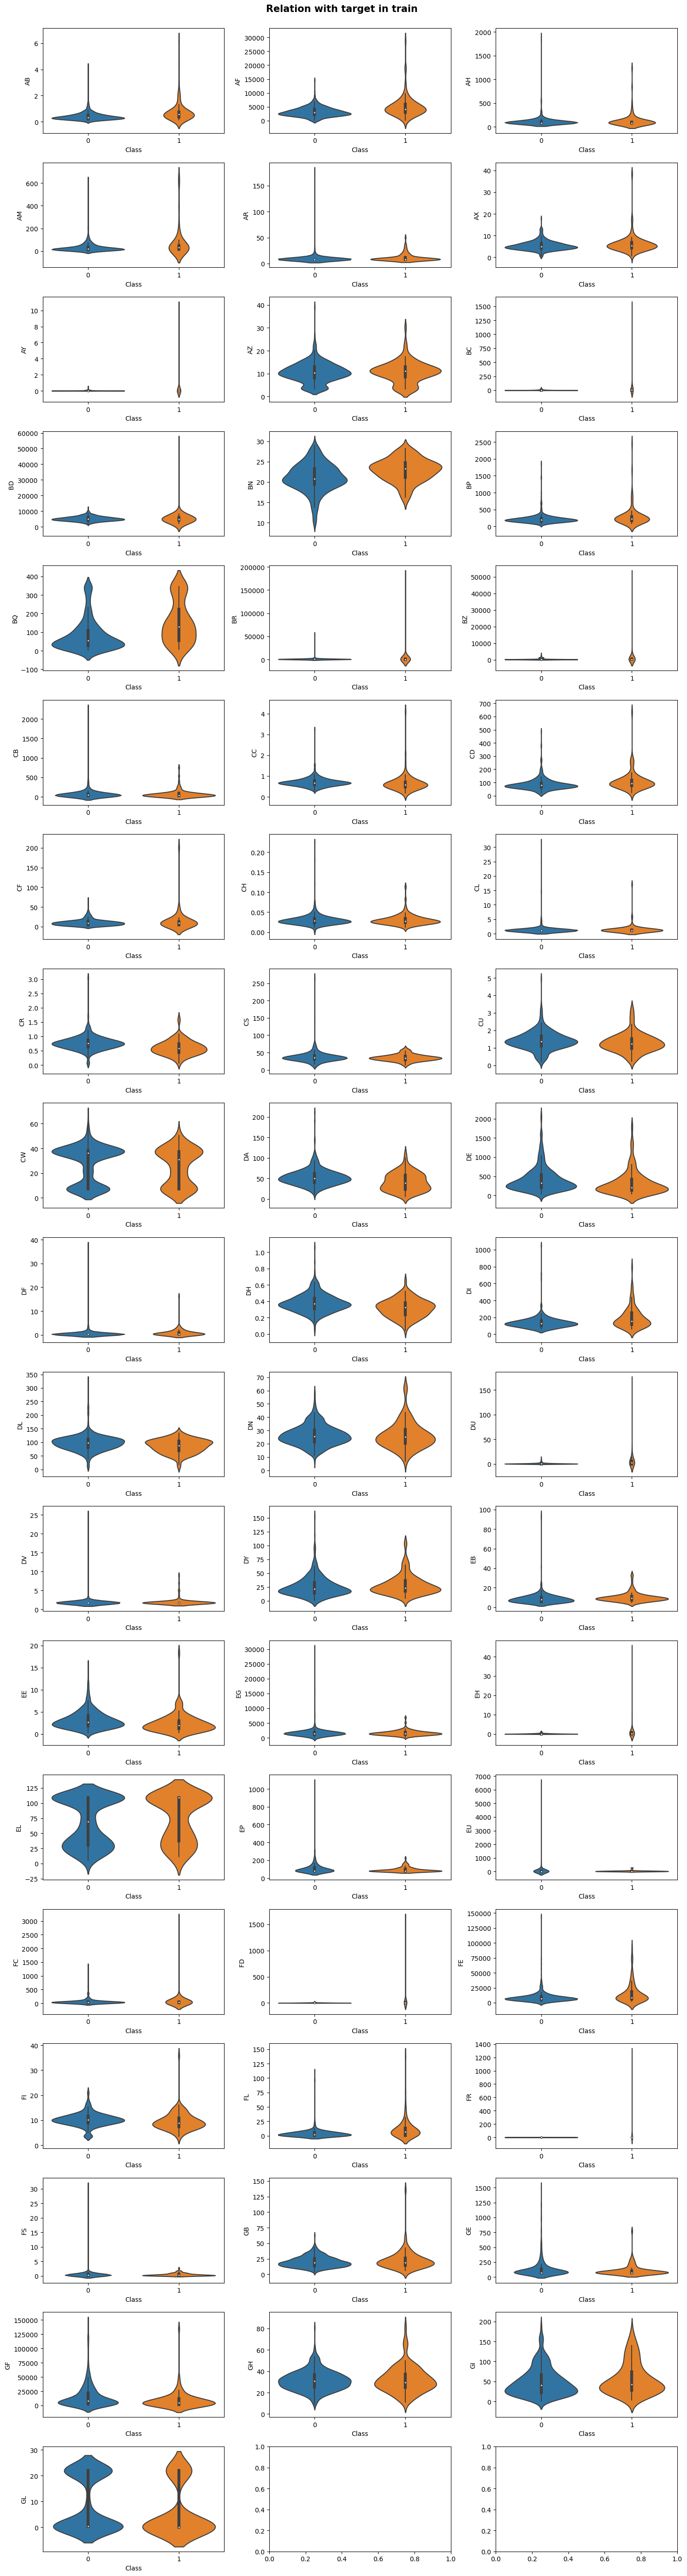

In [20]:
ncols = 3
nrows = int(np.ceil(len(num_feats) / ncols))
train_nbins = get_nbins(train)


fig, ax = plt.subplots(nrows, ncols, figsize=(15, 3*nrows))
axes =  ax.flatten()

for index, col in enumerate(num_feats):
    plot_categorical(train, x=target, y=col, violin=True, ax=axes[index], title="")
    

fig.suptitle("Relation with target in train \n\n\n\n\n", fontsize=15, fontweight='bold')    
plt.tight_layout()

<div class="text-color">
<b>Insights:</b>
    <ul>
        <li>The distribution of the features are mosly skewed to the left</li>
        <li>Some features also show bimodal and kinda normal distribution</li>
        <li>A lot of outliers are present which needs to be investigated</li>
    </ul>
</div>

In [21]:
ej_pivot = pd.pivot_table(data=train, columns=target, index='EJ', values="Id", aggfunc='count', margins=True)
ej_pivot['0_perc'] = ej_pivot[0] / ej_pivot['All'] * 100
ej_pivot['1_perc'] = ej_pivot[1] / ej_pivot['All'] * 100

ej_pivot

Class,0,1,All,0_perc,1_perc
EJ,,,,,
A,194,28,222,87.387387,12.612613
B,315,80,395,79.746835,20.253165
All,509,108,617,82.495948,17.504052


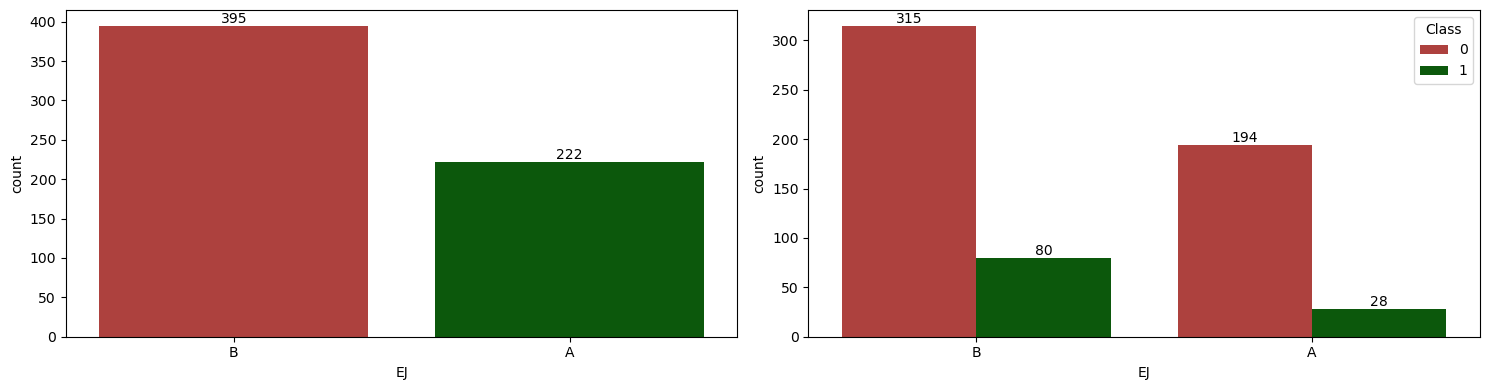

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

sns.countplot(data=train, x=cat_feats[0], ax=ax[0], palette=custom_palette)
ax[0].bar_label(ax[0].containers[0])

sns.countplot(data=train, x=cat_feats[0], hue=target, ax=ax[1], palette=custom_palette)
for container in ax[1].containers:
    ax[1].bar_label(container)

plt.tight_layout()

<div class="text-color">
<b>Insights:</b>
    <ul>
        <li>The only categorical feature seems a little imbalanced</li>
        <li>It seems that on it's own EJ feature does not have much influence on target but it may effect the target being affected other features</li>
    </ul>
</div>

## HeatMap

In [23]:
from scipy.cluster.hierarchy  import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

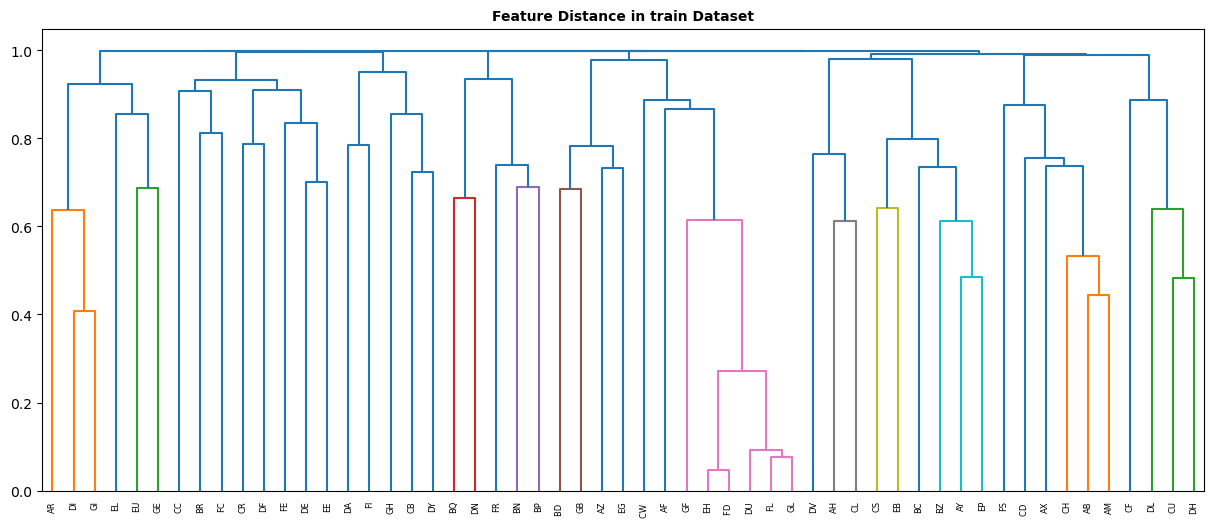

In [24]:
correlations = correlation_dendrogram(train, num_feats, label='train', threshold=0.98)

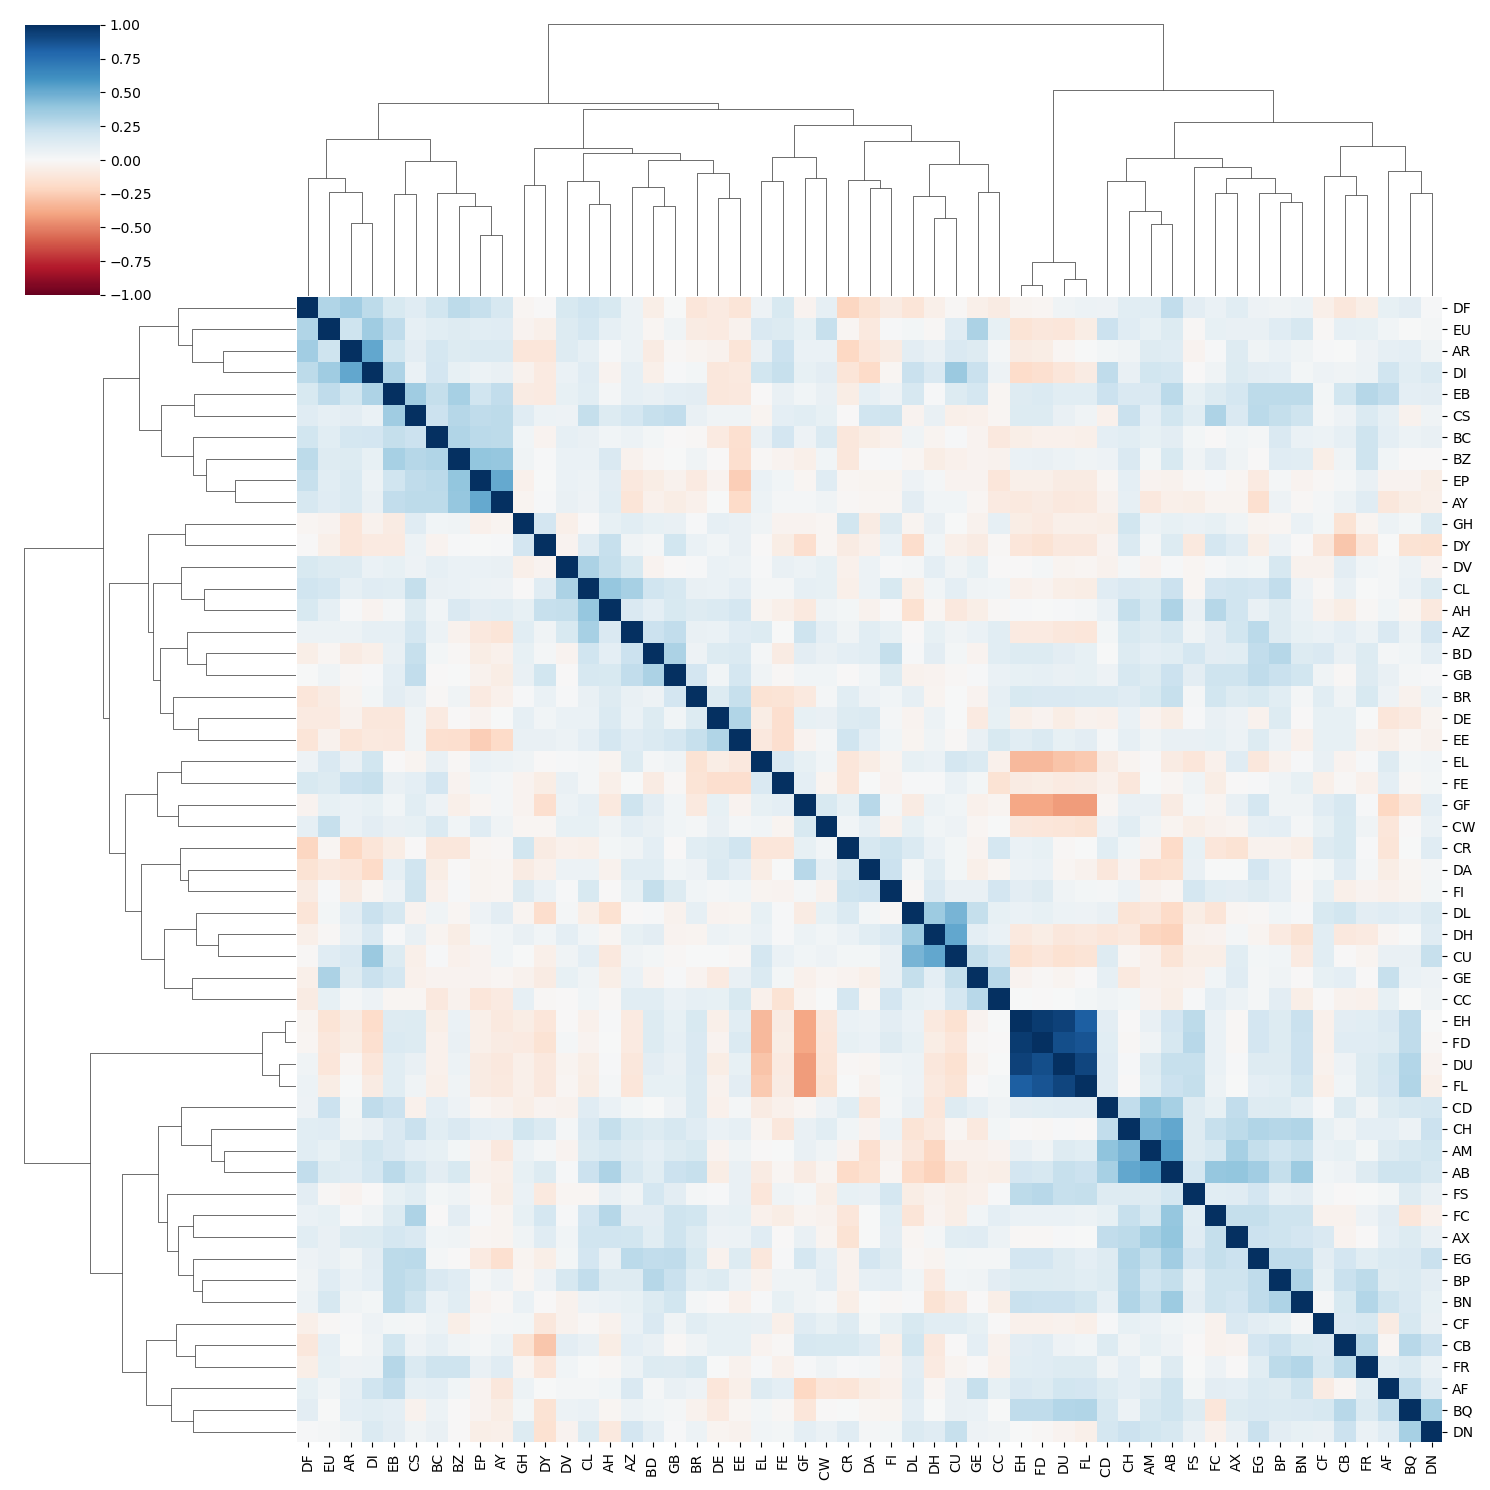

In [25]:
sns.clustermap(correlations, method="complete", cmap='RdBu', annot=False, vmin=-1, vmax=1, figsize=(15,15));

<div class="text-color">
<b>Insights:</b>
    <ul>
        <li>There seems to be two cluster only(if we consider the upper left one a cluster too</li>
    </ul>
</div>

## PCA